In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk

In [ ]:
import json

kaggle_api = {
    "username": "rinkyrizvi",
    "key": "26bc0a3c2666be40abd8d3a7654b9bc1"
}

# Save to kaggle.json
with open("kaggle.json", "w") as file:
    json.dump(kaggle_api, file)



In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import kagglehub


path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

In [ ]:
import os

# List all files inside the dataset folder
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

In [ ]:
csv_path = '/kaggle/input/amazon-fine-food-reviews/Reviews.csv'

# Read the dataset
df = pd.read_csv(csv_path)
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df['Text'].values[0]

In [ ]:
df = df.sample(n=5000, random_state=42)


In [ ]:
print(df.shape)

In [ ]:
df.columns

# Missing & Duplicates

In [ ]:
# Missing values
df.isnull().sum().sort_values(ascending=False)




In [ ]:
df['Summary'] = df['Summary'].fillna('No Summary')


In [ ]:
# Duplicate reviews
df.duplicated().sum()


#Score Distribution (Sentiment Insight)

In [ ]:
sns.countplot(data=df, x='Score')
plt.title('Review Score Distribution')
plt.xlabel('Score (1 = Bad, 5 = Great)')
plt.ylabel('Number of Reviews')
plt.show()


In [ ]:
print(df['Score'].value_counts().sort_index())


#Helpfulness Ratio

In [ ]:
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['HelpfulnessRatio'] = df['HelpfulnessRatio'].fillna(0)

# Histogram of helpfulness
df['HelpfulnessRatio'].plot(kind='hist', bins=20, title='Helpfulness Ratio Distribution')


In [ ]:
# Bin counts for HelpfulnessRatio
helpfulness_bins = pd.cut(df['HelpfulnessRatio'], bins=20)
helpfulness_counts = helpfulness_bins.value_counts().sort_index()
print(helpfulness_counts)


# Review Length Analysis

In [ ]:
df['TextLength'] = df['Text'].apply(len)

# length vs score
sns.boxplot(data=df, x='Score', y='TextLength')
plt.title('Review Length vs Score')


In [ ]:
df['TextLength'] = df['Text'].apply(len)
df['TextLength']

# Most Active Users

In [ ]:
top_users = df['UserId'].value_counts().head(10)
print(top_users)


# Time Feature

In [ ]:
import datetime

df['ReviewTime'] = df['Time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df['ReviewYear'] = df['ReviewTime'].dt.year

df['ReviewYear'].value_counts().sort_index().plot(kind='bar', title='Reviews Over Time')


In [ ]:
year_counts = df['ReviewYear'].value_counts().sort_index()
print(year_counts)


# Correlation Between Score and Helpfulness

In [ ]:
sns.boxplot(data=df, x='Score', y='HelpfulnessRatio')
plt.title('Score vs Helpfulness Ratio')


# Word Cloud

In [ ]:
from wordcloud import WordCloud

text = " ".join(review for review in df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Reviews')
plt.show()


In [ ]:
from collections import Counter
from wordcloud import STOPWORDS
import re

# Preprocess the text (basic cleaning)
clean_text = " ".join(review.lower() for review in df['Text'])
clean_text = re.sub(r'[^a-z\s]', '', clean_text)

# Tokenize and remove stopwords
words = clean_text.split()
filtered_words = [word for word in words if word not in STOPWORDS]

# Count frequency
word_freq = Counter(filtered_words)
common_words = word_freq.most_common(20)

# Print top 20 most frequent words
print("Top 20 most common words in reviews:")
for word, freq in common_words:
    print(f"{word}: {freq}")


# VADER SENTIMENT SCORING

In [ ]:
import nltk
nltk.download('vader_lexicon')


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [ ]:
df['Text'].values[10]

In [ ]:
sia.polarity_scores(df['Text'].values[10])

In [ ]:
happy= 'I am so happy'
print(sia.polarity_scores(happy))

In [ ]:
sad = 'I am very sad'
print(sia.polarity_scores(sad))

In [ ]:
#polarity score on the entire dataset
df['vader_scores'] = df['Text'].apply(lambda review: sia.polarity_scores(review))
df.head()

#Separating Vader Scores

In [ ]:
# Extract the scores
vader_df = pd.json_normalize(df['vader_scores'])

# Clean index
df = df.reset_index(drop=True)
vader_df = vader_df.reset_index(drop=True)

# Join back
df = df.join(vader_df)

# See new DataFrame
df[['Score', 'neg', 'neu', 'pos', 'compound']].head()


In [ ]:
ax = sns.barplot(data=df, x='Score', y='compound')
ax.set_title('Average Score by Review Rating')
plt.xlabel('Review Score (1 to 5)')
plt.ylabel('Average Sentiment Score')
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Positive score by Review Score
sns.barplot(data=df, x='Score', y='pos', ax=axs[0])
axs[0].set_title('Average Positive Sentiment by Review Score')

# Negative score by Review Score
sns.barplot(data=df, x='Score', y='neg', ax=axs[1])
axs[1].set_title('Average Negative Sentiment by Review Score')

# Neutral score by Review Score
sns.barplot(data=df, x='Score', y='neu', ax=axs[2])
axs[2].set_title('Average Neutral Sentiment by Review Score')

plt.tight_layout()
plt.show()


# Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#

In [ ]:
happy= 'I am so happy'
print(sia.polarity_scores(happy))

In [ ]:
encoded_text = tokenizer(happy, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)
#

In [ ]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,  # this is key!
        padding=True
    )
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }
    return scores_dict


In [44]:
from tqdm.notebook import tqdm
tqdm.pandas()  # enable tqdm with pandas

# Apply Roberta sentiment scoring
df['roberta_scores'] = df['Text'].progress_apply(polarity_scores_roberta)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [45]:
roberta_df = pd.json_normalize(df['roberta_scores'])
df = pd.concat([df, roberta_df], axis=1)


In [46]:
df[['Text', 'Score', 'roberta_neg', 'roberta_neu', 'roberta_pos']].head()


,Text,Score,roberta_neg,roberta_neu,roberta_pos
0,Having tried a couple of other brands of glute...,5,0.004572,0.032567,0.962860
1,My cat loves these treats. If ever I can't fin...,5,0.003145,0.013015,0.983840
2,A little less than I expected. It tends to ha...,3,0.501474,0.422844,0.075682
3,"First there was Frosted Mini-Wheats, in origin...",2,0.058795,0.318585,0.622620
4,and I want to congratulate the graphic artist ...,5,0.010467,0.048259,0.941274


#Compare Averages per Score (Table View)

In [47]:
# Average sentiment scores by user rating (1 to 5)
comparison = df.groupby('Score')[['compound', 'roberta_pos', 'roberta_neg', 'roberta_neu']].mean()
print(comparison)


       compound  roberta_pos  roberta_neg  roberta_neu
Score                                                 
1      0.003922     0.107011     0.695969     0.197021
2      0.290612     0.196757     0.544725     0.258518
3      0.486679     0.428229     0.285421     0.286350
4      0.737087     0.752083     0.076571     0.171346
5      0.775264     0.877591     0.035215     0.087194


#Plot Comparison — VADER vs RoBERTa (Grouped Bar Charts)
### A. VADER Compound vs RoBERTa Positivity

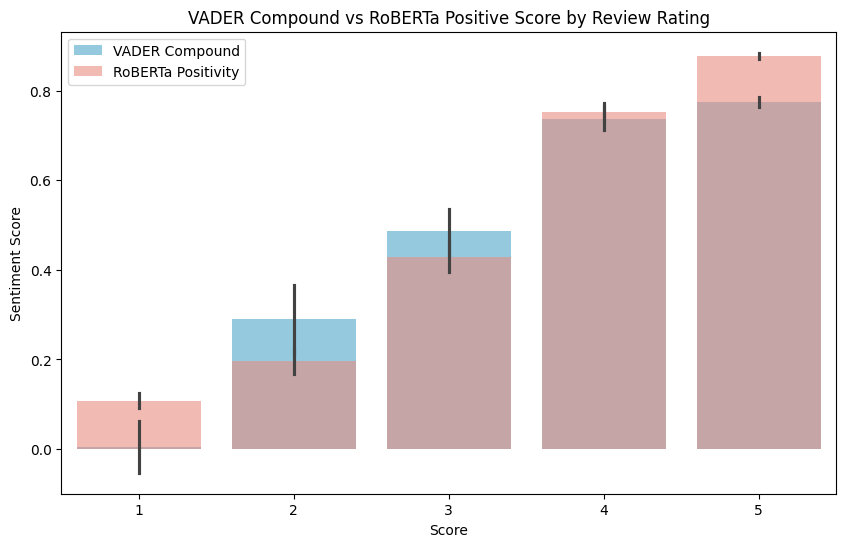

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Score', y='compound', color='skyblue', label='VADER Compound')
sns.barplot(data=df, x='Score', y='roberta_pos', color='salmon', alpha=0.6, label='RoBERTa Positivity')
plt.legend()
plt.title('VADER Compound vs RoBERTa Positive Score by Review Rating')
plt.ylabel('Sentiment Score')
plt.show()


#Group by Score and Take Mean of Sentiment Scores

In [49]:
# Compare average scores grouped by actual review ratings
numeric_comparison = df.groupby('Score')[[
    'neg', 'neu', 'pos', 'compound',
    'roberta_neg', 'roberta_neu', 'roberta_pos'
]].mean().round(3)

# Display the comparison table
print(numeric_comparison)


         neg    neu    pos  compound  roberta_neg  roberta_neu  roberta_pos
Score                                                                      
1      0.095  0.813  0.092     0.004        0.696        0.197        0.107
2      0.079  0.804  0.117     0.291        0.545        0.259        0.197
3      0.057  0.797  0.146     0.487        0.285        0.286        0.428
4      0.036  0.770  0.194     0.737        0.077        0.171        0.752
5      0.031  0.747  0.222     0.775        0.035        0.087        0.878


# Renaming, creating new data frame and merging

In [ ]:
# 1. Rename VADER columns
df.rename(columns={
    'neg': 'vader_neg',
    'neu': 'vader_neu',
    'pos': 'vader_pos',
    'compound': 'vader_compound'
}, inplace=True)

result_df = df[['Text', 'Score',
                'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                'roberta_neg', 'roberta_neu', 'roberta_pos']].copy()
# If your df still has duplicate columns from earlier merges:
df = df.loc[:, ~df.columns.duplicated()]


# Pairplot Comparison

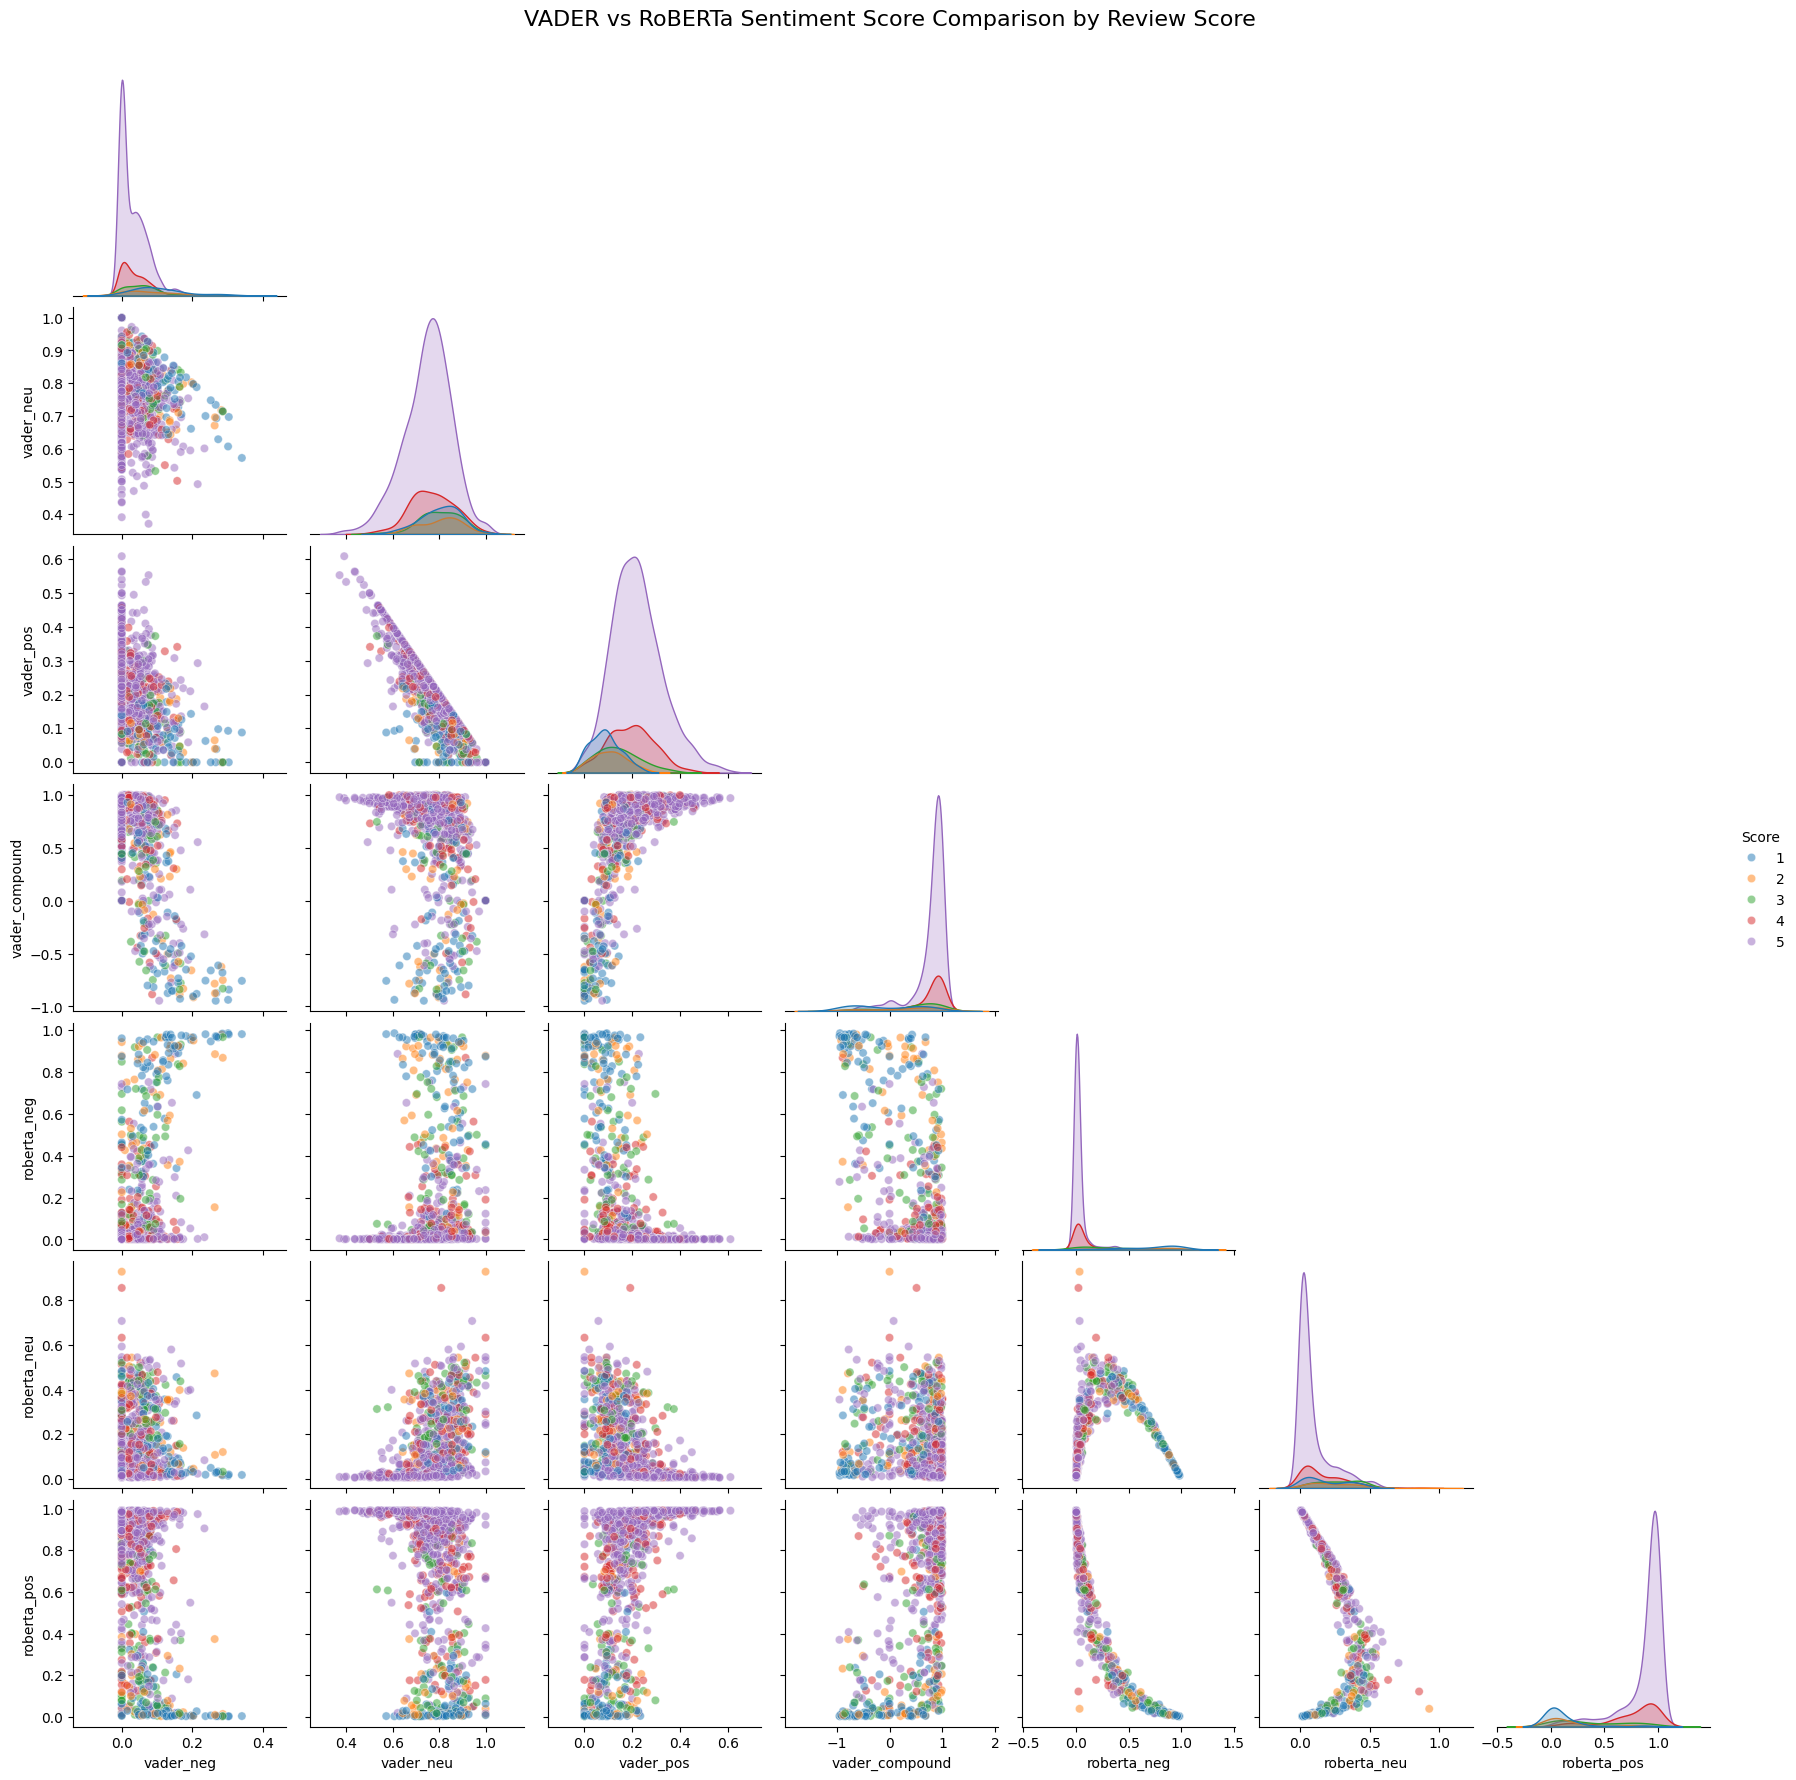

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sentiment columns for comparison
sentiment_columns = [
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'roberta_neg', 'roberta_neu', 'roberta_pos'
]

# Create a smaller sample if too slow
sample_df = result_df.sample(1000, random_state=42)

# Pairplot with hue and color palette
sns.pairplot(sample_df[sentiment_columns + ['Score']],
             hue='Score', palette='tab10', corner=True, plot_kws={'alpha': 0.5})

plt.suptitle('VADER vs RoBERTa Sentiment Score Comparison by Review Score',
             fontsize=16, y=1.02)
plt.show()


#Numerical Comparison (Mean Scores per Rating)

In [52]:
# Group by Score and get average sentiment values
summary_table = result_df.groupby('Score')[sentiment_columns].mean().round(3)

# Display the table
print("Average Sentiment Scores by Review Rating (VADER vs RoBERTa):\n")
print(summary_table)


Average Sentiment Scores by Review Rating (VADER vs RoBERTa):

       vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
Score                                                                 
1          0.095      0.813      0.092           0.004        0.696   
2          0.079      0.804      0.117           0.291        0.545   
3          0.057      0.797      0.146           0.487        0.285   
4          0.036      0.770      0.194           0.737        0.077   
5          0.031      0.747      0.222           0.775        0.035   

       roberta_neu  roberta_pos  
Score                            
1            0.197        0.107  
2            0.259        0.197  
3            0.286        0.428  
4            0.171        0.752  
5            0.087        0.878  


# Review Examples

#Roberta_pos for 1-Star Review

In [53]:
print(df.columns.tolist())


['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'HelpfulnessRatio', 'TextLength', 'ReviewTime', 'ReviewYear', 'vader_scores', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_scores', 'roberta_neg', 'roberta_neu', 'roberta_pos']


In [55]:
result_df = df[['Text', 'Score',
                'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                'roberta_neg', 'roberta_neu', 'roberta_pos']]
result_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]


'As I stated above, this is a great product for cats.  My four cats, some old some young, love it.  Especially my 5 years old male tabby.<br /><br />And, the store shipping the product is really fast.  Thank you...my cats George and Gracie thank you.<br />Carol Sheats'

#vader_pos for 1-Star Review

In [56]:
# Highest VADER positive score among 1-star reviews
result_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]


'UPDATE: BUT 5 stars GO TO AMAZON WHO ISSUED A CREDIT FOR MY LAST ORDER OF THIS PRODUCT! GOOD WORK AND THANK YOU AMAZON, I AM IMPRESSED!!! -Mo<br />..........................................<br /><br />(change from 5 stars to 1) CANCEL THIS PRAISE OF THIS PRODUCT! It DOES contain BPA! -Mo<br />..........................................<br /><br />This is *great* fish; no BPA, no added salt (*I* choose what and if salt is added), I LOVE lots of eatable fish bones (top calcium availability), congratulations Crown Prince and thank you for canning fish I can eat without BPA!'

# Compare VADER and RoBERTa side-by-side

In [57]:
# View top 5 mismatches (Score = 1 but positive sentiment)
mismatches = result_df.query('Score == 1').sort_values(['vader_pos', 'roberta_pos'], ascending=False)

# Select key columns for comparison
mismatches[['Score', 'Text', 'vader_pos', 'vader_compound', 'roberta_pos']].head(5)


,Score,Text,vader_pos,vader_compound,roberta_pos
1481,1,UPDATE: BUT 5 stars GO TO AMAZON WHO ISSUED A ...,0.374,0.9927,0.982245
3709,1,"Good aroma, good mouth feel, but the taste...f...",0.373,0.8658,0.398119
2262,1,Our family has liked every other flavored we h...,0.296,0.9441,0.264085
1754,1,I read many reviews before buying both Jet Fue...,0.257,0.9692,0.353471
2003,1,"I guess if you like Stevia, it's the best way ...",0.257,0.8170,0.176085


#Most Negative RoBERTa Sentiment in 5-Star Reviews

In [58]:
# Find 5-star review with highest roberta_neg score
result_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]


'These are the same product as the Bite-Size in the smaller blue bag except that they\'re longer links and vary in length.<br /><br />The ingredient list is somewhat gross as it lists specific parts of the pig.  If you can get past that, the taste is unmatched!<br /><br />The Slim-Jim ingredient list was similarly disturbing to me as Slim-Jim has, as separate ingredients "chicken" and "mechanically-separated chicken."  I don\'t understand why one or the other doesn\'t cover both.'

#Most Negative VADER Sentiment in 5-Star Reviews

In [59]:
# Find 5-star review with highest vader_neg score
result_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]


'Great price.  Fast shipping.  Be aware of this alternative to sugar.  Plant based, no calories, no carbs, no artificial ingredients, no chemicals!'

# Top Mismatches with High Negativity (RoBERTa or VADER)

In [60]:
# Get top 5-star reviews with high negative scores
neg_mismatches = result_df.query('Score == 5').sort_values(['roberta_neg', 'vader_neg'], ascending=False)

# Select relevant columns to inspect
neg_mismatches[['Score', 'Text', 'roberta_neg', 'vader_neg', 'vader_compound']].head(5)


,Score,Text,roberta_neg,vader_neg,vader_compound
2027,5,These are the same product as the Bite-Size in...,0.930322,0.079,-0.7506
4233,5,I don't understand why other reviewers are com...,0.924978,0.076,-0.2695
4433,5,While I swear by this product and have ordered...,0.905546,0.116,-0.7139
4867,5,I have bought several different brands of pig ...,0.888409,0.016,0.3382
2417,5,Why did Snyder's drop this product? Was I the ...,0.885241,0.151,0.6177


In [61]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [62]:
sent_pipeline("I love sentiment analysis")

[{'label': 'POSITIVE', 'score': 0.999736487865448}]